In [160]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner
import seaborn as sns

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk

In [161]:
star_name = '16CygA'

samples_path = f'stars/{star_name}/gp-test'

logz_list = []
logzerr_list = []

L = [3,5,7,9,11,13,15,17]
S = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

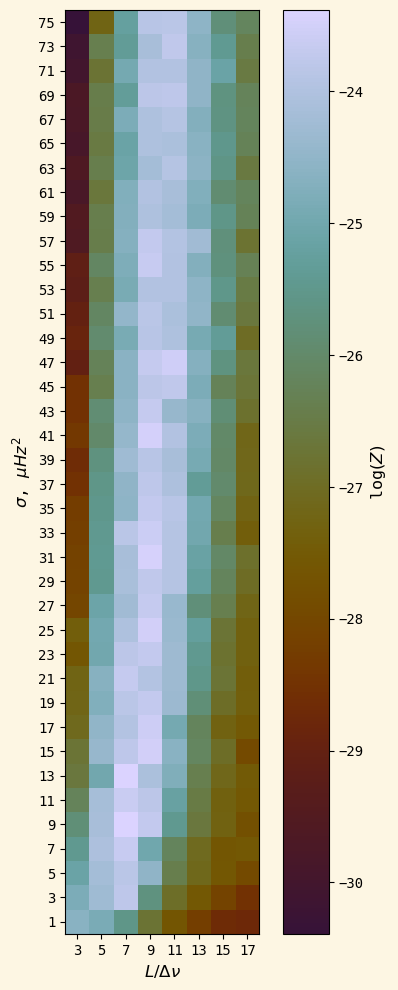

In [162]:
def heatmap(X,Y,C, xlabel=None, ylabel=None, clabel=None, figsize=(6,6), cmap=cm.lajolla):
    fig, ax = plt.subplots(figsize=figsize)
    
    C_array = np.zeros((len(Y), len(X)))
    y_i = len(Y)-1
    c_i = 0
    
    for y in Y:
        x_i=0
        for x in X:
            C_array[y_i, x_i] = C[c_i]
            
            x_i += 1
            c_i +=1

        y_i -= 1
    
    im = ax.imshow(C_array, cmap = cmap)
    fig.colorbar(im, label=clabel)
    ax.grid(False)
    ax.set_xticks(np.arange(len(L)), labels=L)
    ax.set_yticks(np.arange(len(S)), labels=S[::-1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

heatmap(L, S, logz_list, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , clabel=r'log$(Z)$', figsize=(6,12))
    

Text(0, 0.5, '$\\sigma$, $\\mu Hz^{2}$')

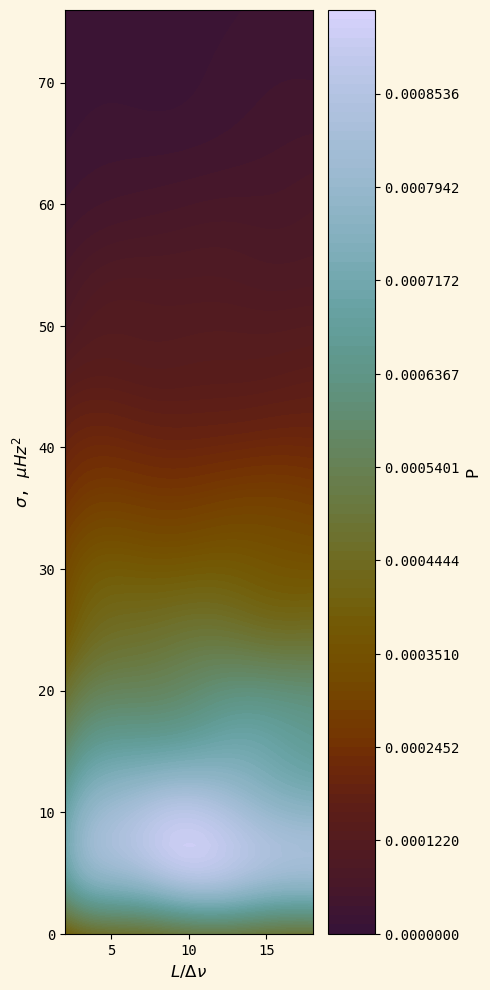

In [165]:
S_dist = scipy.stats.beta(loc=0,scale=200, a=1.1, b=10)
L_dist = scipy.stats.beta(loc=0,scale=36, a=1, b=1)


S_dist_samples =  S_dist.rvs(5000)
L_dist_samples =  L_dist.rvs(5000)

fig, ax = plt.subplots(figsize=(4,12))
sns.kdeplot(x=L_dist_samples, y=S_dist_samples, fill=True, cmap=cm.glasgow, cbar=True, thresh=0, levels=100, cbar_kws={'label':'P'})
ax.set_xlim(2,18)
ax.set_ylim(0,76)
ax.set_xlabel(r'$L / \Delta\nu$')
ax.set_ylabel(r'$\sigma$, $\mu Hz^{2}$')



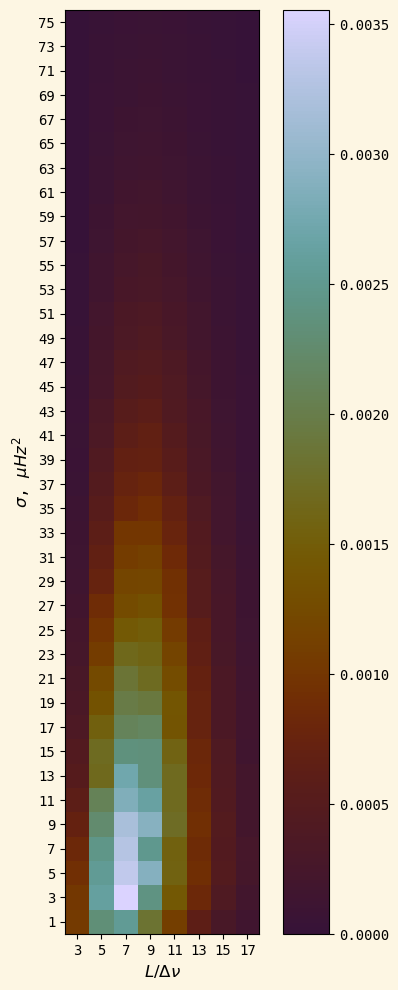

(38, 8)
best GP params:
L = 7
S = 3


In [166]:
def posterior_heatmap(X, X_prior, Y, Y_prior, C, xlabel=None, ylabel=None, clabel=None, figsize=(6,6), cmap=cm.lajolla):
    fig, ax = plt.subplots(figsize=figsize)
    
    C_array = np.zeros((len(Y), len(X)))
    y_i = len(Y)-1
    c_i = 0

    C=np.array(C)

    for y in Y:

        y_posterior = Y_prior.pdf(y)
        x_i=0
        for x in X:
            x_posterior = X_prior.pdf(x)

            xy_posterior = x_posterior * y_posterior

            C_norm = (C[c_i]-C.min())/(C.max()-C.min())
            C_array[y_i, x_i] = C_norm * xy_posterior
            
            x_i += 1
            c_i +=1

        y_i -= 1

    im = ax.imshow(C_array, cmap = cmap)
    fig.colorbar(im, label=clabel)
    ax.grid(False)
    ax.set_xticks(np.arange(len(L)), labels=L)
    ax.set_yticks(np.arange(len(S)), labels=S[::-1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

    print(C_array.shape)
    print("best GP params:")
    print(f"L = {L[np.where(C_array==C_array.max())[1][0]]}")
    print(f"S = {S[(len(S)-1) - np.where(C_array==C_array.max())[0][0]]}") ## this is disgusting

posterior_heatmap(L, L_prior, S, S_prior,  logz_list, 
                  cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , figsize=(6,12))



In [171]:
star_name = '16CygB'

samples_path = f'stars/{star_name}/gp-test'

logz_list = []
logzerr_list = []

L = [3,5,7,9,11,13,15]
S = [1]

for s in S:
    for l in L:
        with open(samples_path+f'/samples_s{s}_l{l}.pkl', 'rb') as fp:
            samples = pickle.load(fp)
        logz_list.append(samples['logz'])
        logzerr_list.append(samples['logzerr'])

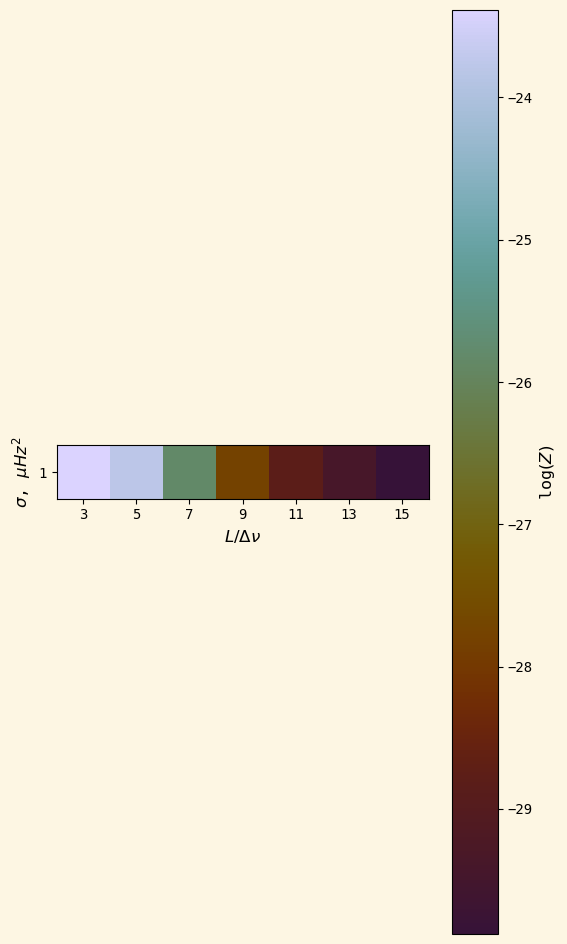

In [172]:
heatmap(L, S, logz_list, cmap=cm.glasgow, xlabel=r'$L / \Delta\nu$' , ylabel= r'$\sigma$, $\mu Hz^{2}$' , clabel=r'log$(Z)$', figsize=(6,12))

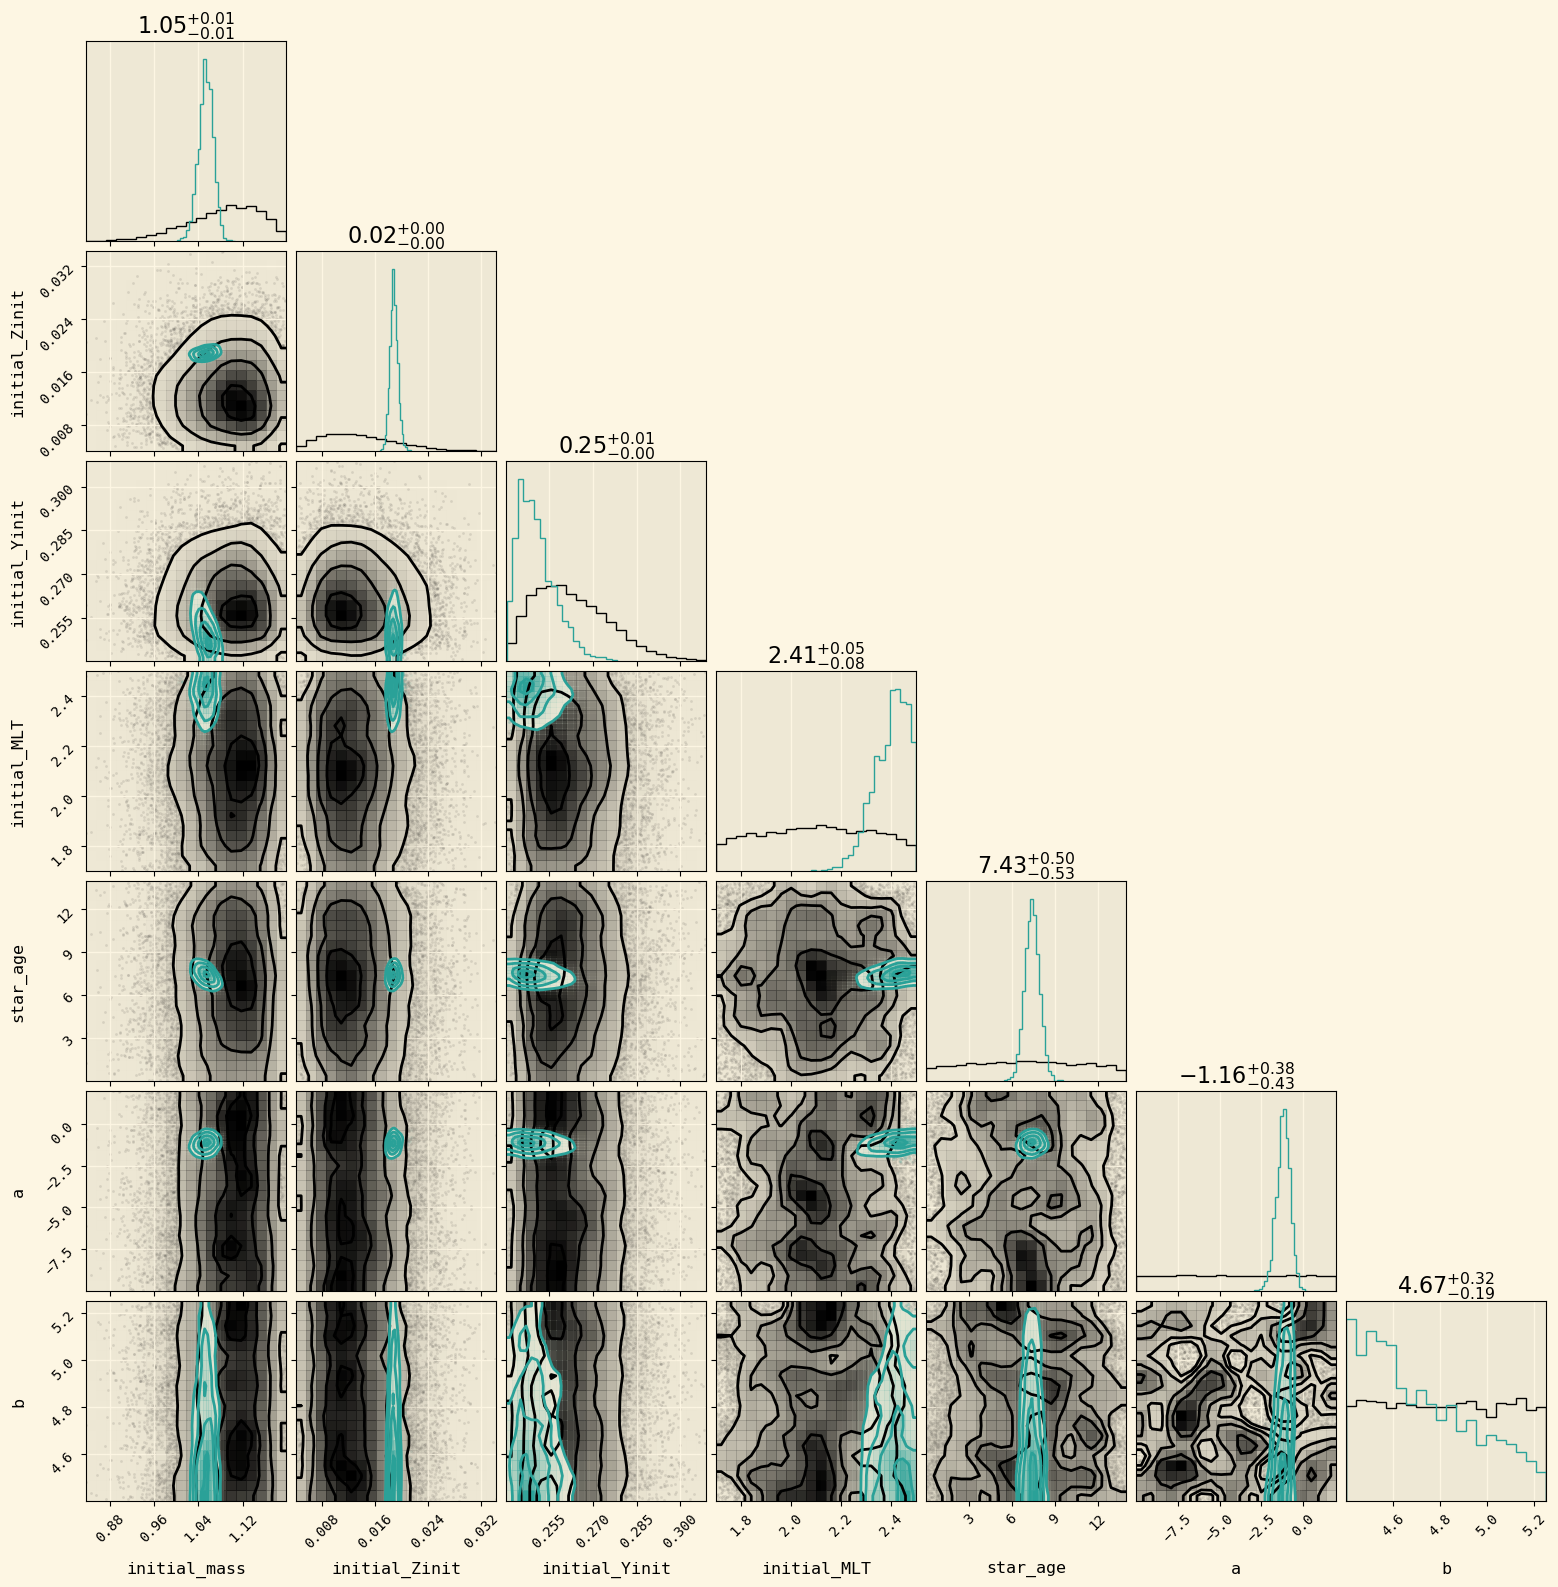

In [173]:
def inspect_star(path, s, l):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    
    path = f'stars/{star_name}/'
    
    star_json = path + f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

    with open(path+f'gp-test/samples_s{s}_l{l}.pkl', 'rb') as fp:
     samples = pickle.load(fp)
        
    #corner.corner(samples['samples'], fig=figure, color=colors[1], truths = published_inps, hist_kwargs={'density':True}, smooth=True,show_titles=True);
    corner.corner(samples['samples'], fig=figure, color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);
    plt.show()

path = f'stars/{star_name}/'

s = 1
l = 15
inspect_star(path, s,l)